In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

from scipy.optimize import linear_sum_assignment

In [6]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()

households = list(prob_df.index)
types = ['ES', 'PSH', 'TH', 'RRH', 'PREV']

prob_df.head()

,HouseholdID,Real,Reentered,ES,PSH,TH,RRH,PREV
1,2028039,2,0,0.425008,0.271801,0.350017,0.397626,0.291637
2,2036520,2,0,0.327550,0.188743,0.266543,0.337444,0.218234
3,2108682,2,0,0.186973,0.760772,0.137805,0.178759,0.106168
4,2116994,2,0,0.234827,0.217690,0.183896,0.239388,0.148293
5,2154639,2,0,0.299406,0.554693,0.232651,0.265632,0.190321


In [7]:
capacity_df

5    6202
1    4441
3    2451
4     846
2     271
Name: Real, dtype: int64

In [8]:
increase_from_best_df = prob_df.copy()
increase_from_best_df['Best'] = increase_from_best_df[types].min(axis=1)
for type_ in types:
    increase_from_best_df[type_] = prob_df[type_] - increase_from_best_df['Best']
    
increase_from_best_df.head()

,HouseholdID,Real,Reentered,ES,PSH,TH,RRH,PREV,Best
1,2028039,2,0,0.153207,0.000000,0.078216,0.125825,0.019835,0.271801
2,2036520,2,0,0.138807,0.000000,0.077800,0.148701,0.029491,0.188743
3,2108682,2,0,0.080806,0.654604,0.031637,0.072591,0.000000,0.106168
4,2116994,2,0,0.086533,0.069397,0.035603,0.091095,0.000000,0.148293
5,2154639,2,0,0.109084,0.364372,0.042330,0.075311,0.000000,0.190321


In [9]:
increase_from_best_df.tail()

,HouseholdID,Real,Reentered,ES,PSH,TH,RRH,PREV,Best
14207,200190370,1,0,0.111995,0.000000,0.090105,0.113371,0.016140,0.169862
14208,200190408,1,0,0.210660,0.000000,0.135338,0.193936,0.083942,0.099490
14209,200191251,1,1,0.287202,0.000000,0.204748,0.259365,0.146592,0.259967
14210,200195065,1,0,0.150201,0.152831,0.098911,0.125306,0.000000,0.311884
14211,200197619,3,0,0.095308,0.043950,0.043950,0.064384,0.000000,0.103372


In [7]:
cost_matrix = np.zeros((prob_df.shape[0], prob_df.shape[0]))
cost_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
steps = [0]
for i in range(1, 6):
    steps.append(steps[-1] + capacity_df[i])

for household_id, household in enumerate(households):
    for type_id, type_ in enumerate(types):
        cost_matrix[
            household_id, steps[type_id]: steps[type_id + 1]
        ] = increase_from_best_df.loc[household, type_]
        
cost_matrix

array([[0.15320713, 0.15320713, 0.15320713, ..., 0.01983546, 0.01983546,
        0.01983546],
       [0.13880676, 0.13880676, 0.13880676, ..., 0.02949065, 0.02949065,
        0.02949065],
       [0.08080555, 0.08080555, 0.08080555, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28720194, 0.28720194, 0.28720194, ..., 0.14659188, 0.14659188,
        0.14659188],
       [0.15020126, 0.15020126, 0.15020126, ..., 0.        , 0.        ,
        0.        ],
       [0.095308  , 0.095308  , 0.095308  , ..., 0.        , 0.        ,
        0.        ]])

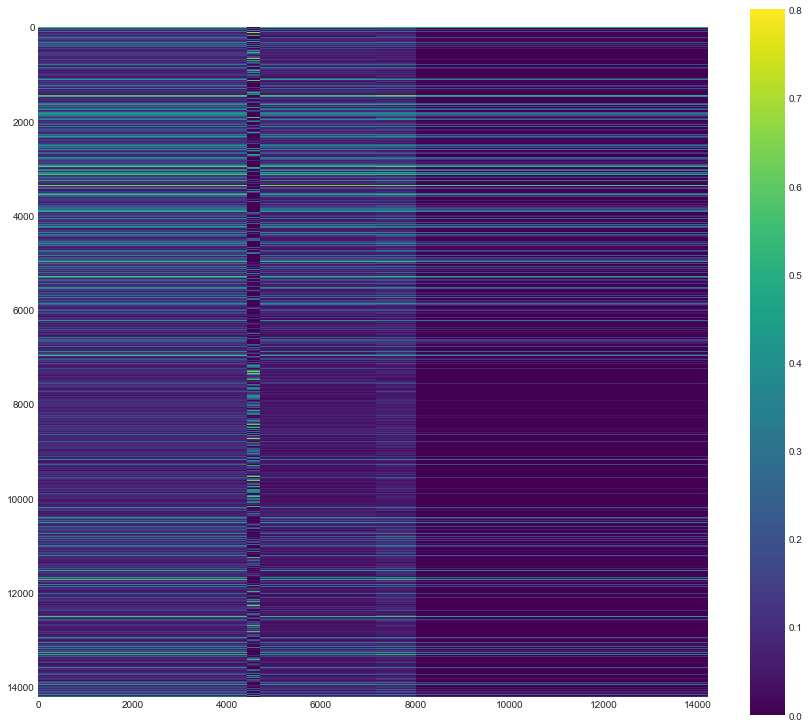

In [9]:
plt.figure(figsize=(15, 13))

plt.imshow(cost_matrix, cmap='viridis')
plt.colorbar()

plt.show()

In [10]:
MULTIPLIER = 10

def efficient_search(matrix):
    # Set up starting objects
    original_matrix = matrix.copy()
    replacement = original_matrix.max() * MULTIPLIER
    sorted_nums = np.unique(original_matrix)
    c_star = np.concatenate([matrix.min(axis=0), matrix.min(axis=1)]).max()
    sorted_nums = sorted_nums[sorted_nums > c_star]

    while len(sorted_nums) > 0:
        print(f'c*: {c_star:.7f}')
        
        valid_matrix = np.ones(matrix.shape)
        matrix[matrix > c_star] = replacement
        valid_matrix[matrix > c_star] = 0
        
        print('Solving the linear sum assignment')
        row_ind, col_ind = linear_sum_assignment(matrix)
        print('Done solving')
        if valid_matrix[row_ind, col_ind].all():
            return row_ind, col_ind

        # Increment c* to the next number and update objects
        c_star = sorted_nums[0]
        sorted_nums = sorted_nums[1:]
        matrix = original_matrix.copy()
    
    return False

In [11]:
sample_cost_matrix = np.array([
    [np.pi, np.sqrt(3), 54392],
    [0, np.e ** 3, np.e ** 3],
    [-2, np.sin(np.pi / 8), 4]
])
valid_matrix = np.ones(sample_cost_matrix.shape)

c_star = 4
sample_cost_matrix[sample_cost_matrix > c_star] = sample_cost_matrix.max()
valid_matrix[sample_cost_matrix > c_star] = 0

row_ind, col_ind = linear_sum_assignment(sample_cost_matrix)
print(row_ind, col_ind)
print(sample_cost_matrix[row_ind, col_ind].sum())

print(valid_matrix[row_ind, col_ind].all())

[0 1 2] [1 0 2]
5.732050807568877
True


In [12]:
sample_cost_matrix = np.array([
    [np.pi, np.sqrt(3), 54392],
    [0, np.e ** 3, np.e ** 3],
    [-2, np.sin(np.pi / 8), 4]
])
efficient_search(sample_cost_matrix.copy())

c*: 4.0000000
Solving the linear sum assignment
Done solving


(array([0, 1, 2]), array([1, 0, 2]))

In [13]:
sample_cost_matrix = np.array([
    [8, 2, 3, 3],
    [2, 7, 5, 8],
    [0, 9, 8, 4],
    [2, 5, 6, 3]
])
valid_matrix = np.ones(sample_cost_matrix.shape)

c_star = 5
sample_cost_matrix[sample_cost_matrix > c_star] = sample_cost_matrix.max()
valid_matrix[sample_cost_matrix > c_star] = 0

row_ind, col_ind = linear_sum_assignment(sample_cost_matrix)
print(row_ind, col_ind)
print(sample_cost_matrix[row_ind, col_ind].sum())

print(valid_matrix[row_ind, col_ind].all())

[0 1 2 3] [1 2 0 3]
10
True


In [14]:
sample_cost_matrix = np.array([
    [8, 2, 3, 3],
    [2, 7, 5, 8],
    [0, 9, 8, 4],
    [2, 5, 6, 3]
])
efficient_search(sample_cost_matrix.copy())

c*: 3.0000000
Solving the linear sum assignment
Done solving
c*: 4.0000000
Solving the linear sum assignment
Done solving
c*: 5.0000000
Solving the linear sum assignment
Done solving


(array([0, 1, 2, 3]), array([1, 2, 0, 3]))

In [15]:
result = efficient_search(cost_matrix)

c*: 0.0210950
Solving the linear sum assignment


KeyboardInterrupt: 

# Scratch paper

In [1]:
import pandas as pd
import numpy as np
import pulp

import sys
sys.path.insert(0, '../..')
import bottleneck_assignment_v2

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

In [2]:
helper = bottleneck_assignment_v2.BottleneckAssignmentHelper(
    np.array([
        [8, 2, 3, 3],
        [2, 7, 5, 8],
        [0, 9, 8, 4],
        [2, 5, 6, 3]
    ]),
    [1, 1, 1, 1]
)

helper.solve()

c*: 3.0000000, count: 0
c*: 4.0000000, count: 1
c*: 5.0000000, count: 2


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [3]:
helper = bottleneck_assignment_v2.BottleneckAssignmentHelper(
    np.array([
        [np.pi, np.sqrt(3), 54392],
        [0, np.e ** 3, np.e ** 3],
        [-2, np.sin(np.pi / 8), 4]
    ]),
    [1, 1, 1]
)

helper.solve()

c*: 4.0000000, count: 0


array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [4]:
prob_df = pd.read_csv('../../data/data.csv', index_col=0)
capacity_df = prob_df['Real'].value_counts()
types = ['ES', 'PSH', 'TH', 'RRH', 'PREV']

increase_from_best_df = prob_df.copy()
increase_from_best_df['Best'] = increase_from_best_df[types].min(axis=1)
for type_ in types:
    increase_from_best_df[type_] = prob_df[type_] - increase_from_best_df['Best']
increase_from_best_df = increase_from_best_df[types]

helper = bottleneck_assignment_v2.BottleneckAssignmentHelper(
    increase_from_best_df.to_numpy(), capacity_df.sort_index().to_numpy(),
    init_c_star=0.4
)

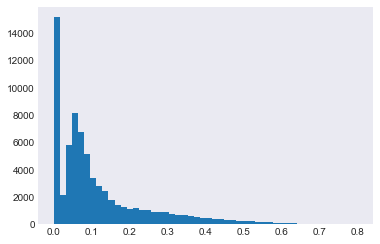

In [5]:
plt.hist(increase_from_best_df.to_numpy().flatten(), bins=50)
plt.show()

In [6]:
helper.solve()

c*: 0.4000000, count: 0


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4000291, count: 1


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4000361, count: 2


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4000707, count: 3


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4000874, count: 4


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4001172, count: 5


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4001202, count: 6


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4002692, count: 7


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4002984, count: 8


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4003121, count: 9


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4003227, count: 10


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4003324, count: 11


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4003877, count: 12


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4003992, count: 13


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4004889, count: 14


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4004910, count: 15


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4004933, count: 16


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4005164, count: 17


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4005540, count: 18


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4005730, count: 19


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4006291, count: 20


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4006710, count: 21


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4006724, count: 22


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4007101, count: 23


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4008265, count: 24


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4008521, count: 25


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4008659, count: 26


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4008821, count: 27


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4009923, count: 28


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4009997, count: 29


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4010056, count: 30


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4010210, count: 31


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4010618, count: 32


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4010873, count: 33


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4011001, count: 34


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4011498, count: 35


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4011619, count: 36


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4011809, count: 37


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4012343, count: 38


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4012416, count: 39


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4012424, count: 40


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4013222, count: 41


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4013307, count: 42


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4013509, count: 43


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4013672, count: 44


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4013837, count: 45


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4014061, count: 46


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4014234, count: 47


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4014748, count: 48


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4015457, count: 49


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4015872, count: 50


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016044, count: 51


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016064, count: 52


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016140, count: 53


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016280, count: 54


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016288, count: 55


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4016938, count: 56


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4017331, count: 57


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4017973, count: 58


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4018111, count: 59


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4018393, count: 60


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4018662, count: 61


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4018789, count: 62


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4018955, count: 63


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4019406, count: 64


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4019982, count: 65


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4020145, count: 66


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4020594, count: 67


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4021449, count: 68


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4022204, count: 69


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4022967, count: 70


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4023263, count: 71


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4023397, count: 72


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4023617, count: 73


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4023683, count: 74


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4023743, count: 75


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4024246, count: 76


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4024857, count: 77


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4025140, count: 78


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4025160, count: 79


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4026516, count: 80


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4026551, count: 81


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4026751, count: 82


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4026834, count: 83


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4027835, count: 84


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4028109, count: 85


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4028699, count: 86


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4029831, count: 87


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4029859, count: 88


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4030332, count: 89


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4030710, count: 90


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4031368, count: 91


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4031431, count: 92


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4031572, count: 93


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4031664, count: 94


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4032781, count: 95


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4033938, count: 96


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4034058, count: 97


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4034601, count: 98


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4034922, count: 99


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4035277, count: 100


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4036074, count: 101


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4036169, count: 102


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4036330, count: 103


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4036612, count: 104


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4036911, count: 105


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4037027, count: 106


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4037298, count: 107


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4037442, count: 108


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4037891, count: 109


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4037985, count: 110


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4038252, count: 111


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4038423, count: 112


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4039573, count: 113


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4039755, count: 114


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4040642, count: 115


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4040872, count: 116


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4040883, count: 117


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4040927, count: 118


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4041056, count: 119


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4041121, count: 120


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4042260, count: 121


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4042480, count: 122


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4042811, count: 123


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4042935, count: 124


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4042980, count: 125


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4043286, count: 126


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4043594, count: 127


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4043612, count: 128


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4043652, count: 129


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4043666, count: 130


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4044616, count: 131


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4044674, count: 132


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4044757, count: 133


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4045613, count: 134


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4046736, count: 135


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4046749, count: 136


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4047648, count: 137


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4047670, count: 138


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4047747, count: 139


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4047953, count: 140


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4048401, count: 141


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4049184, count: 142


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4049428, count: 143


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4050052, count: 144


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4050633, count: 145


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4050715, count: 146


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051186, count: 147


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051204, count: 148


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051267, count: 149


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051633, count: 150


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051654, count: 151


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4051816, count: 152


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4052191, count: 153


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4052566, count: 154


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4053470, count: 155


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4053738, count: 156


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4053927, count: 157


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4053997, count: 158


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4054539, count: 159


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4054973, count: 160


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055087, count: 161


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055472, count: 162


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055477, count: 163


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055547, count: 164


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055595, count: 165


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055836, count: 166


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055874, count: 167


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4055970, count: 168


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4056035, count: 169


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4056126, count: 170


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4056458, count: 171


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4056487, count: 172


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4057555, count: 173


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4057815, count: 174


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4059120, count: 175


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4059771, count: 176


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4059967, count: 177


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4060646, count: 178


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4060653, count: 179


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4060783, count: 180


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4060895, count: 181


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4060901, count: 182


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061173, count: 183


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061309, count: 184


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061417, count: 185


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061655, count: 186


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061815, count: 187


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061876, count: 188


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4061919, count: 189


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4062252, count: 190


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4062593, count: 191


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4064044, count: 192


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4064118, count: 193


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4064329, count: 194


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4065446, count: 195


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4065461, count: 196


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4066093, count: 197


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4066196, count: 198


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4066447, count: 199


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4067534, count: 200


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4067689, count: 201


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4068130, count: 202


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4068663, count: 203


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4068668, count: 204


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4068866, count: 205


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4069094, count: 206


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4069198, count: 207


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4070217, count: 208


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4070327, count: 209


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4070753, count: 210


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4070800, count: 211


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4071378, count: 212


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4071511, count: 213


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4072238, count: 214


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4072469, count: 215


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4072647, count: 216


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4073078, count: 217


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4073343, count: 218


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4073359, count: 219


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4073750, count: 220


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4074077, count: 221


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4074283, count: 222


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4074572, count: 223


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4074724, count: 224


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4074744, count: 225


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4076109, count: 226


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4076111, count: 227


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4076515, count: 228


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4077071, count: 229


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4077235, count: 230


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4077443, count: 231


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4077623, count: 232


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4078257, count: 233


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4079472, count: 234


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4079481, count: 235


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4080016, count: 236


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4080180, count: 237


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4080353, count: 238


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4081869, count: 239


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4081993, count: 240


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4082407, count: 241


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4083257, count: 242


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4083916, count: 243


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4084710, count: 244


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4084711, count: 245


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4084844, count: 246


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4085096, count: 247


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4085479, count: 248


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4086274, count: 249


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4086394, count: 250


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4086514, count: 251


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4086534, count: 252


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4086565, count: 253


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4087062, count: 254


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4087088, count: 255


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4087319, count: 256


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4087677, count: 257


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088209, count: 258


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088322, count: 259


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088488, count: 260


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088579, count: 261


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088713, count: 262


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088724, count: 263


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4088961, count: 264


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4089022, count: 265


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4090460, count: 266


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4091376, count: 267


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4091966, count: 268


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4092486, count: 269


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4092855, count: 270


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4093563, count: 271


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4093666, count: 272


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4094066, count: 273


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4094342, count: 274


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4094445, count: 275


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4095345, count: 276


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4096015, count: 277


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4096151, count: 278


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4097008, count: 279


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4097287, count: 280


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4098015, count: 281


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4098248, count: 282


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4099020, count: 283


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4099099, count: 284


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4099643, count: 285


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4099755, count: 286


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4100503, count: 287


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4100736, count: 288


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4101140, count: 289


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4101251, count: 290


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4101444, count: 291


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4101664, count: 292


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4101694, count: 293


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4102303, count: 294


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4103041, count: 295


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4103380, count: 296


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4103399, count: 297


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4103671, count: 298


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4104385, count: 299


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4104834, count: 300


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4104865, count: 301


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4105308, count: 302


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4105443, count: 303


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4105875, count: 304


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4106112, count: 305


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4106173, count: 306


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4107074, count: 307


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4108953, count: 308


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4109136, count: 309


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4109228, count: 310


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4109892, count: 311


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4110000, count: 312


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4110430, count: 313


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4110470, count: 314


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112346, count: 315


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112620, count: 316


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112634, count: 317


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112650, count: 318


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112767, count: 319


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112788, count: 320


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112788, count: 321


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112894, count: 322


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4112924, count: 323


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4113000, count: 324


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4114034, count: 325


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4114209, count: 326


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4114292, count: 327


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4114472, count: 328


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4114596, count: 329


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4115768, count: 330


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4115883, count: 331


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4116231, count: 332


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4116394, count: 333


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4116706, count: 334


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4116826, count: 335


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4116836, count: 336


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4117568, count: 337


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4117740, count: 338


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4117816, count: 339


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4117839, count: 340


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4118305, count: 341


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4119866, count: 342


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4119930, count: 343


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4120285, count: 344


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4120582, count: 345


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4122381, count: 346


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4122467, count: 347


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4122616, count: 348


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4123952, count: 349


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4124305, count: 350


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4124626, count: 351


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4124743, count: 352


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4124892, count: 353


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4125335, count: 354


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4125572, count: 355


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4125638, count: 356


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4125704, count: 357


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4125919, count: 358


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4126108, count: 359


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4126525, count: 360


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4126735, count: 361


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4126849, count: 362


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4126939, count: 363


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4127020, count: 364


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4127395, count: 365


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4127731, count: 366


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4128217, count: 367


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4128430, count: 368


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4129534, count: 369


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4129836, count: 370


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4130025, count: 371


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4130140, count: 372


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4130232, count: 373


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4131334, count: 374


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4131440, count: 375


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4131849, count: 376


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4131970, count: 377


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4132214, count: 378


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4132624, count: 379


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4133065, count: 380


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4133184, count: 381


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4133791, count: 382


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4134269, count: 383


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4134946, count: 384


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4135384, count: 385


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4135812, count: 386


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4135888, count: 387


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4136154, count: 388


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4136730, count: 389


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4136814, count: 390


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4137332, count: 391


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4137460, count: 392


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4137666, count: 393


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4137920, count: 394


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4138148, count: 395


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4138288, count: 396


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4138294, count: 397


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4138491, count: 398


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4138760, count: 399


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4139163, count: 400


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4139273, count: 401


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4139412, count: 402


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4139840, count: 403


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4140244, count: 404


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4140745, count: 405


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4140752, count: 406


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4141869, count: 407


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4142125, count: 408


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4142506, count: 409


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4142572, count: 410


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4142736, count: 411


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4142845, count: 412


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4144773, count: 413


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4144911, count: 414


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4145122, count: 415


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4145769, count: 416


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4145935, count: 417


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4146427, count: 418


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4147206, count: 419


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4147766, count: 420


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4147880, count: 421


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148200, count: 422


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148451, count: 423


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148507, count: 424


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148652, count: 425


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148752, count: 426


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4148770, count: 427


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4149077, count: 428


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4149526, count: 429


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4149973, count: 430


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4150359, count: 431


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4150462, count: 432


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4151328, count: 433


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4151512, count: 434


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4151883, count: 435


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4152329, count: 436


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4152640, count: 437


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4152828, count: 438


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4153374, count: 439


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4153538, count: 440


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4153756, count: 441


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4153832, count: 442


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4154146, count: 443


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4154509, count: 444


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4154846, count: 445


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4155076, count: 446


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4155438, count: 447


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4156355, count: 448


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157171, count: 449


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157241, count: 450


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157430, count: 451


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157442, count: 452


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157473, count: 453


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157789, count: 454


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4157817, count: 455


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4158555, count: 456


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4158644, count: 457


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4158705, count: 458


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4159389, count: 459


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4159430, count: 460


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4159546, count: 461


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4159768, count: 462


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4160365, count: 463


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4160879, count: 464


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4160883, count: 465


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4161026, count: 466


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4162032, count: 467


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4162818, count: 468


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4162854, count: 469


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4163312, count: 470


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4163441, count: 471


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4164343, count: 472


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4164681, count: 473


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4164995, count: 474


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4165011, count: 475


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4165255, count: 476


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4166172, count: 477


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4166378, count: 478


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4166478, count: 479


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4166903, count: 480


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4167408, count: 481


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4167450, count: 482


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4168095, count: 483


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4168750, count: 484


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4168889, count: 485


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169496, count: 486


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169501, count: 487


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169571, count: 488


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169636, count: 489


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169644, count: 490


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4169740, count: 491


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4170809, count: 492


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4171213, count: 493


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4172212, count: 494


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4172286, count: 495


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4172721, count: 496


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4172921, count: 497


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4173067, count: 498


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4173319, count: 499


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4173871, count: 500


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4173930, count: 501


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4173955, count: 502


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4174025, count: 503


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4174055, count: 504


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4174915, count: 505


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4175287, count: 506


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4176003, count: 507


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4177204, count: 508


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4177249, count: 509


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4177411, count: 510


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4177413, count: 511


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4178082, count: 512


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4178373, count: 513


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179331, count: 514


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179334, count: 515


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179610, count: 516


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179614, count: 517


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179858, count: 518


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4179975, count: 519


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4180088, count: 520


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4180297, count: 521


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4180946, count: 522


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181163, count: 523


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181388, count: 524


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181408, count: 525


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181507, count: 526


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181637, count: 527


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4181753, count: 528


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4182048, count: 529


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4182926, count: 530


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4182936, count: 531


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4183576, count: 532


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4183624, count: 533


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4184904, count: 534


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4185266, count: 535


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4185619, count: 536


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4186187, count: 537


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4187014, count: 538


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4187089, count: 539


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4187375, count: 540


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4188622, count: 541


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4188864, count: 542


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4189190, count: 543


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4189265, count: 544


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4190485, count: 545


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4190574, count: 546


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4190584, count: 547


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4190768, count: 548


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4190950, count: 549


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4191302, count: 550


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4191383, count: 551


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4193248, count: 552


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4193341, count: 553


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4193530, count: 554


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4193671, count: 555


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4194980, count: 556


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4195192, count: 557


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4195465, count: 558


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4195491, count: 559


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4196345, count: 560


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4196770, count: 561


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4196799, count: 562


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4196924, count: 563


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4196926, count: 564


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4197037, count: 565


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4197103, count: 566


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4197513, count: 567


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4197658, count: 568


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4198981, count: 569


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4199032, count: 570


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4200509, count: 571


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4200539, count: 572


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4200951, count: 573


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4201652, count: 574


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4201661, count: 575


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4202198, count: 576


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4202961, count: 577


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4203121, count: 578


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4203228, count: 579


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4204380, count: 580


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4204635, count: 581


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4205490, count: 582


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4205916, count: 583


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4206457, count: 584


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4206591, count: 585


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4206885, count: 586


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4206942, count: 587


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4207154, count: 588


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4207251, count: 589


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4207892, count: 590


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4208490, count: 591


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4208838, count: 592


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4208935, count: 593


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4209765, count: 594


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4209943, count: 595


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4210626, count: 596


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4210661, count: 597


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4210771, count: 598


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4210837, count: 599


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4211409, count: 600


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4211762, count: 601


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4211823, count: 602


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4212051, count: 603


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4212436, count: 604


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4213442, count: 605


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4213900, count: 606


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4213932, count: 607


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4214906, count: 608


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4215242, count: 609


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4215418, count: 610


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4215652, count: 611


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4215812, count: 612


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4216044, count: 613


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4217285, count: 614


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4217318, count: 615


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4217635, count: 616


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4217642, count: 617


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4217867, count: 618


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4218743, count: 619


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4219038, count: 620


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4219554, count: 621


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4219849, count: 622


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4219883, count: 623


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4220210, count: 624


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221110, count: 625


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221201, count: 626


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221437, count: 627


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221485, count: 628


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221853, count: 629


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4221959, count: 630


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4222116, count: 631


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4222322, count: 632


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4223316, count: 633


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4223383, count: 634


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4224003, count: 635


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4224015, count: 636


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4224998, count: 637


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4225342, count: 638


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4225915, count: 639


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4226360, count: 640


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4226380, count: 641


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4226645, count: 642


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4226736, count: 643


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4227260, count: 644


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4227354, count: 645


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4227593, count: 646


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4228017, count: 647


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4228592, count: 648


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4228762, count: 649


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4229079, count: 650


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4230547, count: 651


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4230664, count: 652


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4230695, count: 653


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4231436, count: 654


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4231691, count: 655


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4232252, count: 656


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4232452, count: 657


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4232743, count: 658


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4233034, count: 659


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4233576, count: 660


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4234369, count: 661


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4234921, count: 662


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4235398, count: 663


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4235573, count: 664


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4235693, count: 665


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4235924, count: 666


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4236001, count: 667


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4236043, count: 668


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4236329, count: 669


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4236785, count: 670


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4236861, count: 671


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4237922, count: 672


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4238067, count: 673


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4238503, count: 674


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4238797, count: 675


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4238991, count: 676


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4239337, count: 677


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4239668, count: 678


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4239818, count: 679


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4240948, count: 680


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4241500, count: 681


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4241525, count: 682


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4241556, count: 683


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4241579, count: 684


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4242054, count: 685


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4242060, count: 686


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4242391, count: 687


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4243299, count: 688


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4243994, count: 689


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4244305, count: 690


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4244646, count: 691


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4244952, count: 692


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4245455, count: 693


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4245536, count: 694


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4245666, count: 695


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4247554, count: 696


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4247933, count: 697


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248170, count: 698


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248190, count: 699


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248602, count: 700


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248662, count: 701


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248862, count: 702


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4248873, count: 703


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4249849, count: 704


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4250505, count: 705


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4250555, count: 706


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4250579, count: 707


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4250895, count: 708


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4251085, count: 709


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4251483, count: 710


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4251694, count: 711


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4251809, count: 712


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4251820, count: 713


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4252934, count: 714


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4254603, count: 715


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4255985, count: 716


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256215, count: 717


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256257, count: 718


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256460, count: 719


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256491, count: 720


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256911, count: 721


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4256937, count: 722


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4257781, count: 723


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4258006, count: 724


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4258576, count: 725


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4258604, count: 726


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4259095, count: 727


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4259880, count: 728


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4260037, count: 729


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4260570, count: 730


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4260623, count: 731


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4261530, count: 732


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4261559, count: 733


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4261864, count: 734


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4261874, count: 735


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4262656, count: 736


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4262701, count: 737


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4262869, count: 738


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4263497, count: 739


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4263858, count: 740


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4264121, count: 741


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4264598, count: 742


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4265025, count: 743


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4265290, count: 744


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4265885, count: 745


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4266101, count: 746


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4266669, count: 747


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4266751, count: 748


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4267064, count: 749


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4268132, count: 750


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4268543, count: 751


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4268734, count: 752


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4268865, count: 753


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4269057, count: 754


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4269142, count: 755


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4269501, count: 756


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4269538, count: 757


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4269720, count: 758


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4270457, count: 759


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4270903, count: 760


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4271308, count: 761


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4271806, count: 762


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4272334, count: 763


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4272400, count: 764


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4272528, count: 765


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4272766, count: 766


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4273066, count: 767


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4273348, count: 768


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4273898, count: 769


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4274171, count: 770


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4274456, count: 771


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4274892, count: 772


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4276432, count: 773


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4276877, count: 774


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277077, count: 775


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277097, count: 776


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277331, count: 777


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277599, count: 778


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277655, count: 779


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277692, count: 780


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4277739, count: 781


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4278137, count: 782


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4278855, count: 783


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4279126, count: 784


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4279387, count: 785


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4279838, count: 786


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4280130, count: 787


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4280436, count: 788


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4280439, count: 789


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4281987, count: 790


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4282400, count: 791


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4282488, count: 792


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4282547, count: 793


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4282795, count: 794


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4283380, count: 795


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4284718, count: 796


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4284762, count: 797


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4284949, count: 798


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4285185, count: 799


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4285641, count: 800


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4285927, count: 801


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4286137, count: 802


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4286601, count: 803


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4288784, count: 804


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4289418, count: 805


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4289489, count: 806


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4289636, count: 807


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4289724, count: 808


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4290696, count: 809


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4290858, count: 810


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4290907, count: 811


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4291151, count: 812


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4291275, count: 813


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4291642, count: 814


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4291810, count: 815


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4291915, count: 816


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4292611, count: 817


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4294330, count: 818


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4296279, count: 819


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4296401, count: 820


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4296738, count: 821


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4296811, count: 822


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4297736, count: 823


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4298948, count: 824


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4298981, count: 825


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4299344, count: 826


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301077, count: 827


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301090, count: 828


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301244, count: 829


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301380, count: 830


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301447, count: 831


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4301512, count: 832


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4302379, count: 833


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4302645, count: 834


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4304721, count: 835


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4305118, count: 836


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4305189, count: 837


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4305220, count: 838


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4305288, count: 839


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4306765, count: 840


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4306870, count: 841


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4307478, count: 842


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4307531, count: 843


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4307687, count: 844


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4307945, count: 845


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308157, count: 846


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308180, count: 847


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308345, count: 848


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308500, count: 849


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308502, count: 850


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308967, count: 851


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4308986, count: 852


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4309466, count: 853


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4309588, count: 854


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4309873, count: 855


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4310242, count: 856


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4310492, count: 857


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4311447, count: 858


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4311465, count: 859


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4311547, count: 860


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4311811, count: 861


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4312139, count: 862


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4312144, count: 863


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4312776, count: 864


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4313023, count: 865


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4313077, count: 866


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4313768, count: 867


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4313929, count: 868


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4315167, count: 869


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4315406, count: 870


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4315675, count: 871


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4316103, count: 872


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4316317, count: 873


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4316345, count: 874


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4316838, count: 875


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4318104, count: 876


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4318778, count: 877


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4319065, count: 878


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4319187, count: 879


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4320013, count: 880


/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/pulp/solvers.py:2080: UserWarning: GUROBI_CMD does provide good solution status of non optimal solutions
  warnings.warn('GUROBI_CMD does provide good solution status of non optimal solutions')


c*: 0.4320056, count: 881


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])